# Top overlapping AMR genes by weighted sum for saur cohort

In [83]:
import pandas as pd


pd.set_option("display.max_columns", None) # show all cols
pd.set_option('display.max_colwidth', None) # show full width of showing cols
pd.set_option("display.expand_frame_repr", False) # print cols side by side as it's supposed to be

## Read token information from bed files

In [84]:
import os
import pandas as pd
from pathlib import Path


bedDir = Path(os.environ['GENOMICS_DATA_BASE'], 'genome_nlp_tokens', 'bed_files', 'SAUR')

bedDfList = []
for bedFile in os.listdir(bedDir):
    tubeid = bedFile.split('.')[0].split('_')[0]
    tokensDf = pd.read_csv(Path(bedDir, bedFile), sep='\t', names=['contig_id', 'start_position', 'end_position', 'tokens', 'score'])
    tokensDf['tube_id'] = tubeid
    bedDfList.append(tokensDf)

bedDf = pd.concat(bedDfList, ignore_index=True)
bedDf

,contig_id,start_position,end_position,tokens,score,tube_id
0,1,0,6,TTTTCTT,0.000064,ALF22G140
1,1,7,9,ACC,-0.000395,ALF22G140
2,1,10,13,GACA,0.001573,ALF22G140
3,1,14,18,AGAAT,-0.000986,ALF22G140
4,1,19,25,TAATTAT,0.000795,ALF22G140
...,...,...,...,...,...,...
176721937,5,181665,181667,CGG,-0.002273,AH21C044
176721938,5,181668,181673,CTCATC,-0.001735,AH21C044
176721939,5,181674,181676,GCA,-0.003468,AH21C044
176721940,5,181677,181680,TCCA,-0.000228,AH21C044


## Calculate token length

In [85]:
bedDf['token_length'] = bedDf.tokens.apply(lambda x: len(x))
bedDf

,contig_id,start_position,end_position,tokens,score,tube_id,token_length
0,1,0,6,TTTTCTT,0.000064,ALF22G140,7
1,1,7,9,ACC,-0.000395,ALF22G140,3
2,1,10,13,GACA,0.001573,ALF22G140,4
3,1,14,18,AGAAT,-0.000986,ALF22G140,5
4,1,19,25,TAATTAT,0.000795,ALF22G140,7
...,...,...,...,...,...,...,...
176721937,5,181665,181667,CGG,-0.002273,AH21C044,3
176721938,5,181668,181673,CTCATC,-0.001735,AH21C044,6
176721939,5,181674,181676,GCA,-0.003468,AH21C044,3
176721940,5,181677,181680,TCCA,-0.000228,AH21C044,4


In [86]:
len(bedDf.tokens.unique())

3894

In [87]:
highscoreCutoff = bedDf.score.mean() + 3 * bedDf.score.std()
highscoreCutoff

np.float64(0.012133979502852287)

In [88]:
highscoreDf = bedDf[bedDf.score > highscoreCutoff]
highscoreDf

,contig_id,start_position,end_position,tokens,score,tube_id,token_length
13703,1,75447,75454,TATACTTT,0.013623,ALF22G140,8
13723,1,75557,75561,AATGA,0.014487,ALF22G140,5
13725,1,75567,75572,CCTGAG,0.015546,ALF22G140,6
13753,1,75724,75731,CTGCACCC,0.018303,ALF22G140,8
13785,1,75898,75902,GAGCA,0.018827,ALF22G140,5
...,...,...,...,...,...,...,...
176698433,5,50635,50641,AATGTTT,0.016897,AH21C044,7
176698449,5,50725,50728,ACTG,0.020198,AH21C044,4
176698513,5,51074,51079,GGCGCG,0.015019,AH21C044,6
176698639,5,51802,51807,AAATAT,0.013009,AH21C044,6


In [89]:
highscoreDf.shape

(286987, 7)

In [90]:
highscoreDf.token_length.value_counts()

token_length
6     104579
5      75597
7      51246
4      33151
8      16706
3       2680
9       1348
10       798
2        738
13        73
1         68
11         3
Name: count, dtype: int64

<Axes: xlabel='token_length', ylabel='Count'>

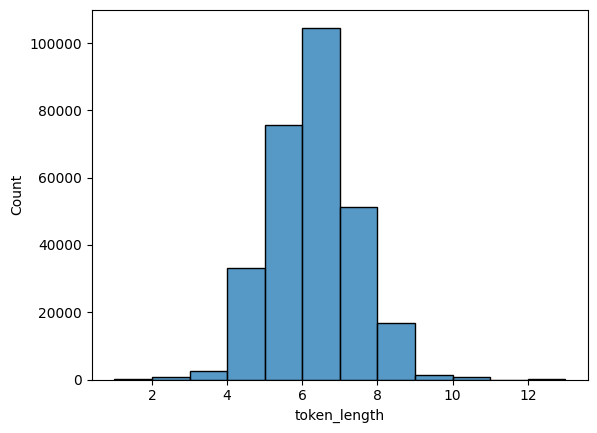

In [91]:
import seaborn as sns


sns.histplot(highscoreDf.token_length, binwidth=1)

## Read bed files containing overlapping tokens and attribution scores

In [92]:
from tqdm import tqdm


amrfinderDir = Path(os.environ['GENOMICS_DATA_BASE'], 'amrfinder')

overlappingDfList = []
for tubeId in tqdm(bedDf.tube_id.unique()):
    tubeidHighscoreDf = highscoreDf[highscoreDf.tube_id == tubeId]
    amrfinderFile = Path(amrfinderDir, tubeId + '_amr_results.txt')
    if(amrfinderFile.exists()):
        amrfinderDf = pd.read_csv(amrfinderFile, sep='\t')
        mergedDf = tubeidHighscoreDf.merge(
            amrfinderDf,
            how='inner',
            left_on = ['contig_id'],
            right_on = ['Contig id'],
        )
        mergedDf['tube_code'] = tubeId
        tubeidOverlappingDf = mergedDf[(mergedDf.start_position >= mergedDf.Start) & (mergedDf.end_position <= mergedDf.Stop)]
        overlappingDfList.append(tubeidOverlappingDf)

overlappingDf = pd.concat(overlappingDfList, ignore_index=True)
overlappingDf

100%|██████████| 557/557 [00:09<00:00, 61.81it/s]


,contig_id,start_position,end_position,tokens,score,tube_id,token_length,Protein identifier,Contig id,Start,Stop,Strand,Gene symbol,Sequence name,Scope,Element type,Element subtype,Class,Subclass,Method,Target length,Reference sequence length,% Coverage of reference sequence,% Identity to reference sequence,Alignment length,Accession of closest sequence,Name of closest sequence,HMM id,HMM description,tube_code
0,3,92632,92637,TGAAGT,0.016457,ALF22G140,6,NaN,3,92622,93371,+,sel26,staphylococcal enterotoxin type 26,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,250,250,100.0,94.80,250,KAG18833.1,staphylococcal enterotoxin type 26,NaN,NaN,ALF22G140
1,3,92734,92739,TAAACT,0.012154,ALF22G140,6,NaN,3,92622,93371,+,sel26,staphylococcal enterotoxin type 26,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,250,250,100.0,94.80,250,KAG18833.1,staphylococcal enterotoxin type 26,NaN,NaN,ALF22G140
2,3,93110,93114,AAAAC,0.013360,ALF22G140,5,NaN,3,92622,93371,+,sel26,staphylococcal enterotoxin type 26,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,250,250,100.0,94.80,250,KAG18833.1,staphylococcal enterotoxin type 26,NaN,NaN,ALF22G140
3,3,93281,93285,GAGTA,0.012412,ALF22G140,5,NaN,3,92622,93371,+,sel26,staphylococcal enterotoxin type 26,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,250,250,100.0,94.80,250,KAG18833.1,staphylococcal enterotoxin type 26,NaN,NaN,ALF22G140
4,5,115189,115193,CCAAT,0.013918,AH20K063,5,NaN,5,113439,115193,+,blaR1,beta-lactam sensor/signal transducer BlaR1,core,AMR,AMR,BETA-LACTAM,BETA-LACTAM,BLASTX,585,585,100.0,91.45,585,WP_001096386.1,beta-lactam sensor/signal transducer BlaR1,NaN,NaN,AH20K063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1606,3,313940,313945,CAGGTG,0.012849,AH20L076,6,NaN,3,312704,314056,+,mepA,multidrug efflux MATE transporter MepA,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,451,451,100.0,99.56,451,BAB41547.1,multidrug efflux MATE transporter MepA,NaN,NaN,AH20L076
1607,3,313975,313979,CTTTG,0.014194,AH20L076,5,NaN,3,312704,314056,+,mepA,multidrug efflux MATE transporter MepA,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,451,451,100.0,99.56,451,BAB41547.1,multidrug efflux MATE transporter MepA,NaN,NaN,AH20L076
1608,3,314026,314030,ACAGT,0.012561,AH20L076,5,NaN,3,312704,314056,+,mepA,multidrug efflux MATE transporter MepA,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,451,451,100.0,99.56,451,BAB41547.1,multidrug efflux MATE transporter MepA,NaN,NaN,AH20L076
1609,1,464540,464543,TTGA,0.013898,AH21C044,4,NaN,1,464367,465893,-,aur,zinc metalloproteinase aureolysin,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,509,509,100.0,99.21,509,EHO93748.1,zinc metalloproteinase aureolysin,NaN,NaN,AH21C044


## Calculate weighted sum for all the genes overlapping with high-score tokens

In [93]:
import numpy as np


geneWeightedsumDf = overlappingDf.groupby(by=['Gene symbol']).agg({'score': np.sum}).reset_index().rename(columns={'score': 'weighted_sum'})
geneWeightedsumDf

/tmp/ipykernel_7911/4136738264.py:4: FutureWarning: The provided callable <function sum at 0x729831f703a0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  geneWeightedsumDf = overlappingDf.groupby(by=['Gene symbol']).agg({'score': np.sum}).reset_index().rename(columns={'score': 'weighted_sum'})


,Gene symbol,weighted_sum
0,aur,3.280601
1,blaI,0.174582
2,blaPC1,0.016080
3,blaR1,0.495845
4,blaZ,0.073253
5,cadD,0.029502
6,cna,0.543924
7,ednB,0.120006
8,fosB,0.385932
9,fusC,0.012427


## Get overlapping genes for the tokens

In [94]:
tokenOverlapsDf = overlappingDf.merge(
    bedDf[['contig_id', 'start_position', 'end_position', 'tokens']],
    on=['contig_id', 'start_position', 'end_position', 'tokens'],
    how='inner',
)
tokenOverlapsDf

,contig_id,start_position,end_position,tokens,score,tube_id,token_length,Protein identifier,Contig id,Start,Stop,Strand,Gene symbol,Sequence name,Scope,Element type,Element subtype,Class,Subclass,Method,Target length,Reference sequence length,% Coverage of reference sequence,% Identity to reference sequence,Alignment length,Accession of closest sequence,Name of closest sequence,HMM id,HMM description,tube_code
0,3,92632,92637,TGAAGT,0.016457,ALF22G140,6,NaN,3,92622,93371,+,sel26,staphylococcal enterotoxin type 26,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,250,250,100.0,94.80,250,KAG18833.1,staphylococcal enterotoxin type 26,NaN,NaN,ALF22G140
1,3,92734,92739,TAAACT,0.012154,ALF22G140,6,NaN,3,92622,93371,+,sel26,staphylococcal enterotoxin type 26,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,250,250,100.0,94.80,250,KAG18833.1,staphylococcal enterotoxin type 26,NaN,NaN,ALF22G140
2,3,93110,93114,AAAAC,0.013360,ALF22G140,5,NaN,3,92622,93371,+,sel26,staphylococcal enterotoxin type 26,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,250,250,100.0,94.80,250,KAG18833.1,staphylococcal enterotoxin type 26,NaN,NaN,ALF22G140
3,3,93110,93114,AAAAC,0.013360,ALF22G140,5,NaN,3,92622,93371,+,sel26,staphylococcal enterotoxin type 26,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,250,250,100.0,94.80,250,KAG18833.1,staphylococcal enterotoxin type 26,NaN,NaN,ALF22G140
4,3,93281,93285,GAGTA,0.012412,ALF22G140,5,NaN,3,92622,93371,+,sel26,staphylococcal enterotoxin type 26,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,250,250,100.0,94.80,250,KAG18833.1,staphylococcal enterotoxin type 26,NaN,NaN,ALF22G140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2261,3,313975,313979,CTTTG,0.014194,AH20L076,5,NaN,3,312704,314056,+,mepA,multidrug efflux MATE transporter MepA,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,451,451,100.0,99.56,451,BAB41547.1,multidrug efflux MATE transporter MepA,NaN,NaN,AH20L076
2262,3,314026,314030,ACAGT,0.012561,AH20L076,5,NaN,3,312704,314056,+,mepA,multidrug efflux MATE transporter MepA,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,451,451,100.0,99.56,451,BAB41547.1,multidrug efflux MATE transporter MepA,NaN,NaN,AH20L076
2263,1,464540,464543,TTGA,0.013898,AH21C044,4,NaN,1,464367,465893,-,aur,zinc metalloproteinase aureolysin,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,509,509,100.0,99.21,509,EHO93748.1,zinc metalloproteinase aureolysin,NaN,NaN,AH21C044
2264,5,67876,67879,TTGA,0.013503,AH21C044,4,NaN,5,67713,68090,-,blaI,penicillinase repressor BlaI,core,AMR,AMR,BETA-LACTAM,BETA-LACTAM,BLASTX,126,126,100.0,96.83,126,WP_001284656.1,penicillinase repressor BlaI,NaN,NaN,AH21C044


In [95]:
len(tokenOverlapsDf.tokens.unique()), len(tokenOverlapsDf['Gene symbol'].unique())

(322, 41)

## Visualise weighted sum

<Axes: xlabel='weighted_sum', ylabel='Count'>

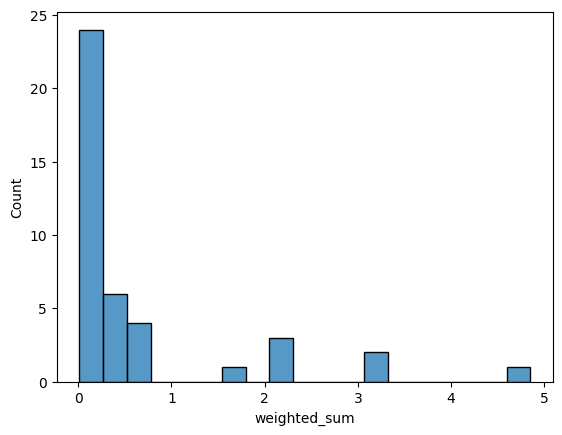

In [96]:
import seaborn as sns


sns.histplot(geneWeightedsumDf.weighted_sum)

## Top genes based on the weighted sum

In [97]:
geneWeightedsumDf.sort_values(by=['weighted_sum'], ascending=False)[:20]

,Gene symbol,weighted_sum
40,tet(38),4.851790
0,aur,3.280601
21,mepA,3.151323
10,hlgA,2.258055
13,icaC,2.188095
11,hlgB,2.051923
12,hlgC,1.664825
30,sel26,0.772692
38,splB,0.653162
14,lmrS,0.634433


## Create gene-type lookup table from amrfinderplus annotations

In [98]:
import os

import pandas as pd

from pathlib import Path


amrfinderDir = Path(os.environ['GENOMICS_DATA_BASE'], 'amrfinder')

amrfinderDfList = []
for amrfinderFile in os.listdir(amrfinderDir):
    amrfinderDf = pd.read_csv(Path(amrfinderDir, amrfinderFile), sep='\t')
    amrfinderDfList.append(amrfinderDf)

allAmrfinderDf = pd.concat(amrfinderDfList, ignore_index=True)
allAmrfinderDf

/tmp/ipykernel_7911/536070399.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  allAmrfinderDf = pd.concat(amrfinderDfList, ignore_index=True)


,Protein identifier,Contig id,Start,Stop,Strand,Gene symbol,Sequence name,Scope,Element type,Element subtype,Class,Subclass,Method,Target length,Reference sequence length,% Coverage of reference sequence,% Identity to reference sequence,Alignment length,Accession of closest sequence,Name of closest sequence,HMM id,HMM description
0,NaN,1,83926,85452,-,aur,zinc metalloproteinase aureolysin,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,509,509,100.00,99.41,509,EHO93748.1,zinc metalloproteinase aureolysin,NaN,NaN
1,NaN,1,128415,129464,+,icaC,polysaccharide intercellular adhesin biosynthesis/export protein IcaC,plus,VIRULENCE,VIRULENCE,NaN,NaN,EXACTX,350,350,100.00,100.00,350,AUU58561.1,polysaccharide intercellular adhesin biosynthesis/export protein IcaC,NaN,NaN
2,NaN,1,150950,154498,-,cna,collagen adhesin Cna,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,1183,1183,100.00,98.31,1183,BAB96477.1,collagen adhesin Cna,NaN,NaN
3,NaN,1,277464,278813,+,tet(38),tetracycline efflux MFS transporter Tet(38),core,AMR,AMR,TETRACYCLINE,TETRACYCLINE,EXACTX,450,450,100.00,100.00,450,WP_001100300.1,tetracycline efflux MFS transporter Tet(38),NaN,NaN
4,NaN,1,505300,506652,+,mepA,multidrug efflux MATE transporter MepA,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,451,451,100.00,99.33,451,BAB41547.1,multidrug efflux MATE transporter MepA,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57610,NaN,17,83399,84580,-,emrD,multidrug efflux MFS transporter EmrD,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,394,394,100.00,99.24,394,ACN65732.1,multidrug efflux MFS transporter EmrD,NaN,NaN
57611,NaN,2,213498,214724,-,kdeA,multidrug efflux MFS transporter KdeA,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,409,410,99.76,99.02,409,ABR76310.1,multidrug efflux MFS transporter KdeA,NaN,NaN
57612,NaN,3,59710,60882,+,oqxA,multidrug efflux RND transporter periplasmic adaptor subunit OqxA,core,AMR,AMR,PHENICOL/QUINOLONE,PHENICOL/QUINOLONE,BLASTX,391,391,100.00,99.23,391,WP_002914189.1,multidrug efflux RND transporter periplasmic adaptor subunit OqxA,NaN,NaN
57613,NaN,3,60909,64058,+,oqxB9,multidrug efflux RND transporter permease subunit OqxB9,core,AMR,AMR,PHENICOL/QUINOLONE,PHENICOL/QUINOLONE,ALLELEX,1050,1050,100.00,100.00,1050,WP_012967412.1,multidrug efflux RND transporter permease subunit OqxB9,NaN,NaN


In [99]:
genetypeLookupDf = allAmrfinderDf[['Gene symbol', 'Element type']].drop_duplicates()
genetypeLookupDf

,Gene symbol,Element type
0,aur,VIRULENCE
1,icaC,VIRULENCE
2,cna,VIRULENCE
3,tet(38),AMR
4,mepA,AMR
...,...,...
55837,blaPDC-58,AMR
56358,blaACT-49,AMR
56951,blaNDM-4,AMR
56963,aac(6')-Ib-cr,AMR


## Add gene descriptions to the top genes

In [100]:
geneWeightedsumDf.sort_values(by=['weighted_sum'], ascending=False)[:20].merge(
    genetypeLookupDf,
    on=['Gene symbol'],
    how='left'
)

,Gene symbol,weighted_sum,Element type
0,tet(38),4.851790,AMR
1,aur,3.280601,VIRULENCE
2,mepA,3.151323,AMR
3,hlgA,2.258055,VIRULENCE
4,icaC,2.188095,VIRULENCE
5,hlgB,2.051923,VIRULENCE
6,hlgC,1.664825,VIRULENCE
7,sel26,0.772692,VIRULENCE
8,splB,0.653162,VIRULENCE
9,lmrS,0.634433,STRESS


## Save all gene hits

In [101]:
import os
import pandas as pd
from pathlib import Path


outputFile = Path(os.environ['GENOMICS_DATA_BASE'], 'temp', 'saur_top_amrgenes_overlaping_3sd_tokens.csv')
geneWeightedsumDf.sort_values(by=['weighted_sum'], ascending=False).merge(
    genetypeLookupDf,
    on=['Gene symbol'],
    how='left'
).drop_duplicates().to_csv(outputFile, index=False)

## Read mapping information

In [102]:
import os

import pandas as pd


demoTrainDf = pd.read_csv(os.environ['EHR_DATA_BASE'] + '/blood_pos_cohort_20240614/data/wb_365_wa_1/splits_v1/demographics/mortality_normal_train.csv', sep='\t')
demoTestDf = pd.read_csv(os.environ['EHR_DATA_BASE'] + '/blood_pos_cohort_20240614/data/wb_365_wa_1/splits_v1/demographics/mortality_normal_test.csv', sep='\t')
demoValidateDf = pd.read_csv(os.environ['EHR_DATA_BASE'] + '/blood_pos_cohort_20240614/data/wb_365_wa_1/splits_v1/demographics/mortality_normal_validate.csv', sep='\t')
demoDf = pd.concat([demoTrainDf, demoTestDf, demoValidateDf], ignore_index=True)
demoDf

,person_id,visit_occurrence_id,TYPE,COUNTRY_OF_BIRTH,SEX,Age_Bin,JOURNEY_ID
0,678487,3312694,Emergency,Australia,Male,"(60, 70]",3312694
1,2094045,9199249,Emergency,Australia,Male,"(20, 30]",9199249
2,2107813,9410987,Emergency,Australia,Male,"(50, 60]",9410987
3,2083212,602890,Inpatient,Australia,Female,"(40, 50]",9039437
4,2083212,9039437,Emergency,Australia,Female,"(40, 50]",9039437
...,...,...,...,...,...,...,...
7194,2603535,16588204,Inpatient,Australia,Male,"(60, 70]",16588204
7195,2603535,16709341,Inpatient,Australia,Male,"(60, 70]",16709341
7196,2603535,16651755,Inpatient,Australia,Male,"(60, 70]",16651755
7197,2098616,16872774,Emergency,Australia,Female,"(80, 90]",16872774


In [103]:
import os

mappingDf = pd.read_csv(os.environ['GENOMICS_DATA_BASE'] + '/patient_tube_id_mapping_full.tsv', sep='\t')
mappingDf

,tube_code,PATIENT_ID,db_ID,pt_age,pt_gender,EPISODE_ID,hospital_admission,hospital_discharge,hospital_in_last_year,genome_species,species_reported,contig_number,length,tube_code_duplicate_or_old,date_of_collection,ID_number,location_additional_02,collected_from_original
0,AH19J072,213972.0,3JNQS,64,Male,12931474.0,2019-10-17,2019-11-29,yes,Escherichia coli,Escherichia coli,92,5131021,NaN,2019-10-30,19-303-0997,A-7EA;HAEM,Blood
1,AH19J074,213972.0,3JNQS,64,Male,12931474.0,2019-10-17,2019-11-29,yes,Streptococcus sp. D19,Streptococcus mitis group,84,2022991,NaN,2019-10-30,19-303-1174,A-7EA;HAEM,Blood Peripheral
2,AH19B003,526238.0,567AE,85,Male,640261.0,2019-02-04,2019-02-07,no,Escherichia coli,Escherichia coli,93,4942915,NaN,2019-02-03,19-034-1596,A-4WB;GMC,Blood
3,AH20A024,788941.0,3YBDS,58,Female,13194824.0,2020-01-16,2020-01-19,no,Escherichia coli,Escherichia coli,110,5149157,NaN,2020-01-16,20-016-2112,S-ED;Emergency,Blood Venous
4,AH20L041,1023735.0,2VJ78,42,Male,14210147.0,2020-12-18,2021-01-05,yes,Staphylococcus aureus,Staphylococcus aureus,46,2735216,NaN,2020-12-16,20-351-2856,Emergency Dept;nan,Blood
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3112,ALF22L076,639020.0,3S6HL,84,Male,17219899.0,2022-12-15,2022-12-20,yes,Streptococcus vestibularis,Streptococcus salivarius group,107,1938627,NaN,2022-12-15,22-349-2150,Ward 4WB,Blood Peripheral
3113,ALF22L089,655404.0,6EWBM,67,Female,NaN,NaN,NaN,NaN,Proteus columbae,Proteus vulgaris,152,3972219,NaN,2022-12-17,22-351-1465,Comm/Amb Clinic,Blood
3114,ALF22L138,2572048.0,YM5PJ,61,Male,NaN,NaN,NaN,NaN,Enterobacter roggenkampii,Enterobacter cloacae complex,66,4876179,NaN,2022-12-27,22-361-0202,Ward 7 East,Hick White Lum
3115,ALF23A102,2054964.0,5DYAH,35,Female,17294287.0,2023-01-12,2023-02-01,yes,Streptococcus constellatus,Streptococcus anginosus group,54,1869828,NaN,2023-01-11,23-011-3305,ICU,Blood Venous


In [104]:
mappedJourneyTubeIdsDf = mappingDf[['tube_code', 'PATIENT_ID', 'EPISODE_ID']].drop_duplicates().merge(
    demoDf[['person_id', 'visit_occurrence_id', 'JOURNEY_ID']],
    how='inner',
    left_on=['PATIENT_ID', 'EPISODE_ID'],
    right_on=['person_id', 'visit_occurrence_id']
).drop(
    columns=['PATIENT_ID', 'EPISODE_ID', 'visit_occurrence_id']
)[['person_id', 'JOURNEY_ID', 'tube_code']].drop_duplicates()
mappedJourneyTubeIdsDf

,person_id,JOURNEY_ID,tube_code
0,50056,13224842,AH20B011
1,62567,12645629,AH19G065
2,138108,14737781,AH21E052
3,211314,13955099,AH20J009
4,211314,13955099,KPN2214
...,...,...,...
512,2084373,16158768,ALF22C004
513,1058066,16759482,ALF22H089
514,2552781,16966609,ALF22J054
515,2638484,16969999,ALF22K143


## Read mortality labels

In [105]:
import os

import pandas as pd

from pathlib import Path


mortalityTrainDf = pd.read_csv(Path(os.environ['EHR_DATA_BASE'], 'blood_pos_cohort_20240614', 'data', 'wb_365_wa_1', 'splits_v1', 'labels', 'mortality', 'mortality_30_day_normal_train.csv'), sep='\t')
mortalityTestDf = pd.read_csv(Path(os.environ['EHR_DATA_BASE'], 'blood_pos_cohort_20240614', 'data', 'wb_365_wa_1', 'splits_v1', 'labels', 'mortality', 'mortality_30_day_normal_test.csv'), sep='\t')
mortalityValidateDf = pd.read_csv(Path(os.environ['EHR_DATA_BASE'], 'blood_pos_cohort_20240614', 'data', 'wb_365_wa_1', 'splits_v1', 'labels', 'mortality', 'mortality_30_day_normal_validate.csv'), sep='\t')
mortalityDf = pd.concat([mortalityTrainDf, mortalityTestDf, mortalityValidateDf], ignore_index=True).drop_duplicates()
mortalityDf

,person_id,JOURNEY_ID,visit_occurrence_id,death_30_day
0,678487,3312694,3312694,0
1,2094045,9199249,9199249,0
2,2107813,9410987,9410987,1
5,2083212,9039437,602890,0
6,2083212,9039437,9039437,0
...,...,...,...,...
30815,2603535,16588204,16588204,0
30820,2603535,16709341,16709341,0
30832,2603535,16651755,16651755,0
30838,2098616,16872774,16872774,0


## Create annotations data matrix

In [106]:
geneWeightedsumDf

,Gene symbol,weighted_sum
0,aur,3.280601
1,blaI,0.174582
2,blaPC1,0.016080
3,blaR1,0.495845
4,blaZ,0.073253
5,cadD,0.029502
6,cna,0.543924
7,ednB,0.120006
8,fosB,0.385932
9,fusC,0.012427


In [107]:

signatureAnnotationsDf = tokenOverlapsDf[tokenOverlapsDf['Gene symbol'].isin(geneWeightedsumDf.sort_values(by=['weighted_sum'], ascending=False)[:20]['Gene symbol'])]
signatureAnnotationsDf


,contig_id,start_position,end_position,tokens,score,tube_id,token_length,Protein identifier,Contig id,Start,Stop,Strand,Gene symbol,Sequence name,Scope,Element type,Element subtype,Class,Subclass,Method,Target length,Reference sequence length,% Coverage of reference sequence,% Identity to reference sequence,Alignment length,Accession of closest sequence,Name of closest sequence,HMM id,HMM description,tube_code
0,3,92632,92637,TGAAGT,0.016457,ALF22G140,6,NaN,3,92622,93371,+,sel26,staphylococcal enterotoxin type 26,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,250,250,100.0,94.80,250,KAG18833.1,staphylococcal enterotoxin type 26,NaN,NaN,ALF22G140
1,3,92734,92739,TAAACT,0.012154,ALF22G140,6,NaN,3,92622,93371,+,sel26,staphylococcal enterotoxin type 26,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,250,250,100.0,94.80,250,KAG18833.1,staphylococcal enterotoxin type 26,NaN,NaN,ALF22G140
2,3,93110,93114,AAAAC,0.013360,ALF22G140,5,NaN,3,92622,93371,+,sel26,staphylococcal enterotoxin type 26,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,250,250,100.0,94.80,250,KAG18833.1,staphylococcal enterotoxin type 26,NaN,NaN,ALF22G140
3,3,93110,93114,AAAAC,0.013360,ALF22G140,5,NaN,3,92622,93371,+,sel26,staphylococcal enterotoxin type 26,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,250,250,100.0,94.80,250,KAG18833.1,staphylococcal enterotoxin type 26,NaN,NaN,ALF22G140
4,3,93281,93285,GAGTA,0.012412,ALF22G140,5,NaN,3,92622,93371,+,sel26,staphylococcal enterotoxin type 26,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,250,250,100.0,94.80,250,KAG18833.1,staphylococcal enterotoxin type 26,NaN,NaN,ALF22G140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2259,3,313884,313889,ACAAGG,0.012786,AH20L076,6,NaN,3,312704,314056,+,mepA,multidrug efflux MATE transporter MepA,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,451,451,100.0,99.56,451,BAB41547.1,multidrug efflux MATE transporter MepA,NaN,NaN,AH20L076
2260,3,313940,313945,CAGGTG,0.012849,AH20L076,6,NaN,3,312704,314056,+,mepA,multidrug efflux MATE transporter MepA,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,451,451,100.0,99.56,451,BAB41547.1,multidrug efflux MATE transporter MepA,NaN,NaN,AH20L076
2261,3,313975,313979,CTTTG,0.014194,AH20L076,5,NaN,3,312704,314056,+,mepA,multidrug efflux MATE transporter MepA,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,451,451,100.0,99.56,451,BAB41547.1,multidrug efflux MATE transporter MepA,NaN,NaN,AH20L076
2262,3,314026,314030,ACAGT,0.012561,AH20L076,5,NaN,3,312704,314056,+,mepA,multidrug efflux MATE transporter MepA,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,451,451,100.0,99.56,451,BAB41547.1,multidrug efflux MATE transporter MepA,NaN,NaN,AH20L076


In [108]:
signatureDataDf = signatureAnnotationsDf[['tube_code', 'Gene symbol']].drop_duplicates()
# Get one hot encoding of columns B
one_hot = pd.get_dummies(signatureDataDf['Gene symbol'])
# Drop column B as it is now encoded
signatureDataDf = signatureDataDf.drop('Gene symbol',axis = 1)
# Join the encoded df
signatureDataDf = signatureDataDf.join(one_hot)
signatureDataDf = signatureDataDf.loc[:, (signatureDataDf != 0).any(axis=0)]
signatureDataDf = signatureDataDf*1
signatureDataDf

,tube_code,aur,blaR1,cna,fosB,hlgA,hlgB,hlgC,icaC,lmrS,lukD,lukE,mecR1,mepA,sak,sei,sel26,sen,splA,splB,tet(38)
0,ALF22G140,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
5,AH20K063,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,ALF22L022,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,AH20I029,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
20,ALF22G118,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2219,AH20F023,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2223,ALF22E107,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2232,AH20L076,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2238,AH20L076,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


### Create datamatrix

In [109]:
dataDf = mortalityDf.merge(
    mappedJourneyTubeIdsDf,
    on=['person_id', 'JOURNEY_ID'],
    how='inner'
).drop(
    columns=['visit_occurrence_id']
).drop_duplicates().merge(
    signatureDataDf,
    on=['tube_code'],
    how='inner'
).drop(
    columns=['tube_code']
)
dataDf = dataDf.loc[:, (dataDf != 0).any(axis=0)]
dataDf

,person_id,JOURNEY_ID,death_30_day,aur,fosB,hlgA,hlgB,hlgC,icaC,lukD,lukE,sel26,splA,splB,tet(38)
0,2145022,601149,1,0,0,0,0,0,0,0,0,0,0,0,1
1,2217919,678046,0,0,0,1,0,0,0,0,0,0,0,0,0
2,2217919,678046,0,0,0,0,0,1,0,0,0,0,0,0,0
3,2217919,678046,0,0,0,0,1,0,0,0,0,0,0,0,0
4,2091319,12511190,0,0,0,0,0,0,0,0,0,1,0,0,0
5,2249297,12716442,0,0,0,0,0,0,0,0,0,0,1,0,0
6,2253645,12747284,0,0,0,0,0,0,0,0,0,0,0,0,1
7,2199146,12819409,1,0,0,0,0,0,0,0,1,0,0,0,0
8,2199146,12819409,1,0,0,0,0,0,0,1,0,0,0,0,0
9,1935470,13075078,1,0,0,0,1,0,0,0,0,0,0,0,0


### Calculate correlation

In [110]:
dataDf.drop(columns=['person_id', 'JOURNEY_ID']).corr().sort_values('death_30_day', ascending=False)

,death_30_day,aur,fosB,hlgA,hlgB,hlgC,icaC,lukD,lukE,sel26,splA,splB,tet(38)
death_30_day,1.000000,-0.216845,0.266398,0.104447,0.104447,0.014456,0.104447,0.104447,0.104447,-0.121090,-0.216845,-0.121090,-0.018182
fosB,0.266398,-0.057767,1.000000,-0.046374,-0.046374,-0.057767,-0.046374,-0.046374,-0.046374,-0.032258,-0.057767,-0.032258,-0.121090
hlgB,0.104447,-0.083045,-0.046374,-0.066667,1.000000,-0.083045,-0.066667,-0.066667,-0.066667,-0.046374,-0.083045,-0.046374,-0.174078
hlgA,0.104447,-0.083045,-0.046374,1.000000,-0.066667,-0.083045,-0.066667,-0.066667,-0.066667,-0.046374,-0.083045,-0.046374,-0.174078
lukD,0.104447,-0.083045,-0.046374,-0.066667,-0.066667,-0.083045,-0.066667,1.000000,-0.066667,-0.046374,-0.083045,-0.046374,-0.174078
lukE,0.104447,-0.083045,-0.046374,-0.066667,-0.066667,-0.083045,-0.066667,-0.066667,1.000000,-0.046374,-0.083045,-0.046374,-0.174078
icaC,0.104447,-0.083045,-0.046374,-0.066667,-0.066667,-0.083045,1.000000,-0.066667,-0.066667,-0.046374,-0.083045,-0.046374,-0.174078
hlgC,0.014456,-0.103448,-0.057767,-0.083045,-0.083045,1.000000,-0.083045,-0.083045,-0.083045,-0.057767,-0.103448,-0.057767,-0.216845
tet(38),-0.018182,-0.216845,-0.121090,-0.174078,-0.174078,-0.216845,-0.174078,-0.174078,-0.174078,-0.121090,-0.216845,-0.121090,1.000000
sel26,-0.121090,-0.057767,-0.032258,-0.046374,-0.046374,-0.057767,-0.046374,-0.046374,-0.046374,1.000000,-0.057767,-0.032258,-0.121090


### Plot correlations as a heatmap

<Axes: >

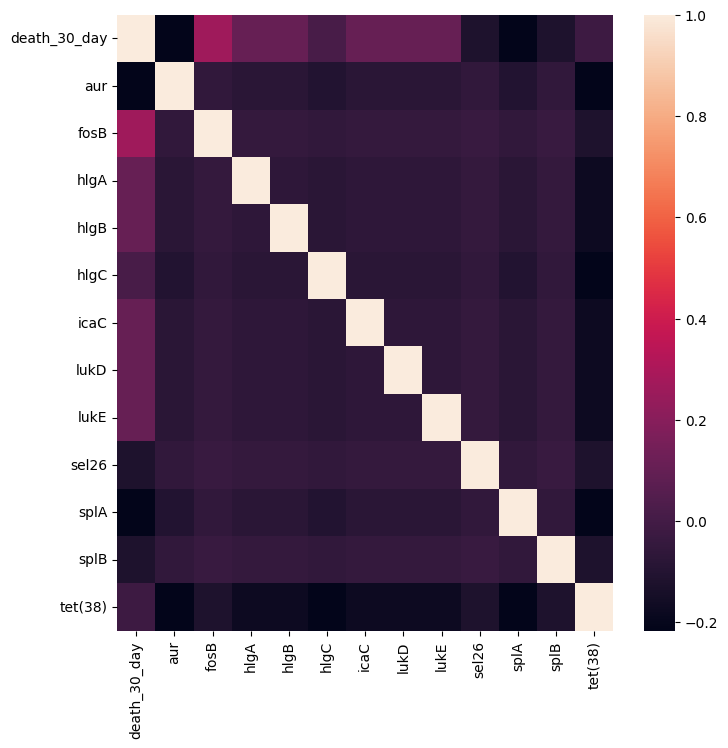

In [111]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from matplotlib.colors import SymLogNorm


f, ax = plt.subplots(1, 1, figsize=(8, 8))

# plot the heatmap
sns.heatmap(dataDf.drop(columns=['person_id', 'JOURNEY_ID']).corr())

### Plot correlations as a heatmap (Log scale)

<Axes: >

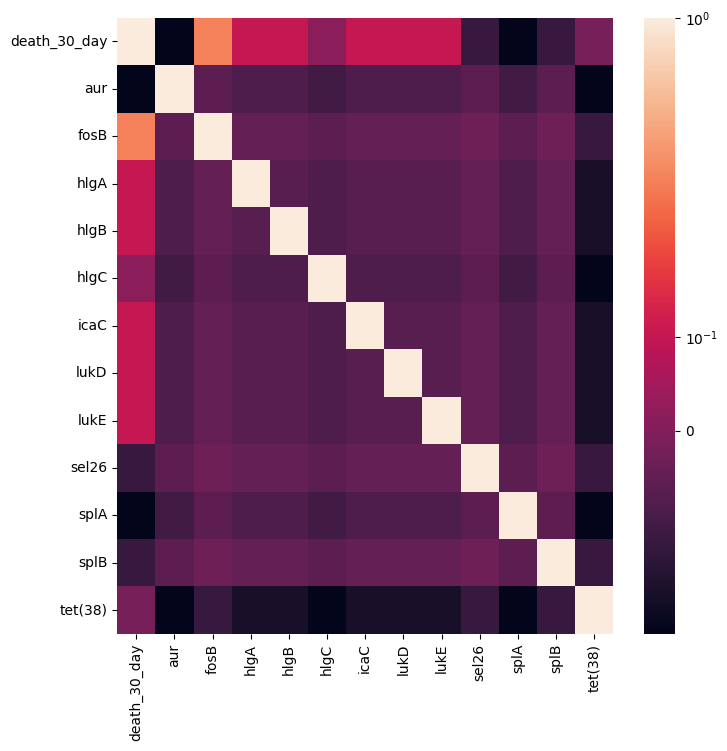

In [112]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from matplotlib.colors import SymLogNorm


f, ax = plt.subplots(1, 1, figsize=(8, 8))

# plot the heatmap
sns.heatmap(dataDf.drop(columns=['person_id', 'JOURNEY_ID']).corr(), norm=SymLogNorm(linthresh=0.3))

### Model using machine learning

In [113]:
X = dataDf.drop(columns=['person_id', 'JOURNEY_ID', 'death_30_day'])
y = dataDf.death_30_day

In [114]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)

accuracy_score(y_test, y_pred)

0.42857142857142855

In [115]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
lrc = LogisticRegression(random_state=0)
y_pred = lrc.fit(X_train, y_train).predict(X_test)

accuracy_score(y_test, y_pred)

0.42857142857142855

In [116]:
coefficients = lrc.coef_[0]
featureImportanceDf = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients
    }).sort_values(by=['Coefficient'])
featureImportanceDf

,Feature,Coefficient
0,aur,-0.497450
9,splA,-0.497450
11,tet(38),-0.233820
2,hlgA,-0.210115
10,splB,-0.210115
8,sel26,-0.210115
4,hlgC,-0.210115
3,hlgB,0.361038
5,icaC,0.361038
7,lukE,0.361038


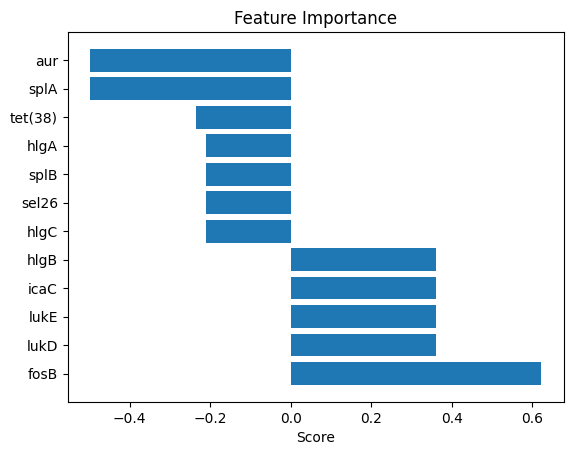

In [117]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots()

ax.barh(y=featureImportanceDf.Feature, width=featureImportanceDf.Coefficient, align='center')
# ax.set_yticks(y_pos, labels=people)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Score')
ax.set_title('Feature Importance')

plt.show()


## Create tokens data matrix

In [118]:
import numpy as np


tokenWeightedsumDf = overlappingDf.groupby(by=['tokens']).agg({'score': np.sum}).reset_index().rename(columns={'score': 'weighted_sum'})
tokenWeightedsumDf

/tmp/ipykernel_7911/2946855819.py:4: FutureWarning: The provided callable <function sum at 0x729831f703a0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  tokenWeightedsumDf = overlappingDf.groupby(by=['tokens']).agg({'score': np.sum}).reset_index().rename(columns={'score': 'weighted_sum'})


,tokens,weighted_sum
0,AAAAAAT,0.012697
1,AAAAACAA,0.029719
2,AAAAATCA,0.015529
3,AAAAC,0.013360
4,AAAAGA,0.012205
...,...,...
317,TTTGT,0.131396
318,TTTTAAAA,0.106590
319,TTTTAC,0.032316
320,TTTTCTTT,0.056686


In [119]:
signatureTokensDf = overlappingDf[overlappingDf['tokens'].isin(tokenWeightedsumDf.sort_values(by=['weighted_sum'], ascending=False)[:20]['tokens'])]
signatureTokensDf

,contig_id,start_position,end_position,tokens,score,tube_id,token_length,Protein identifier,Contig id,Start,Stop,Strand,Gene symbol,Sequence name,Scope,Element type,Element subtype,Class,Subclass,Method,Target length,Reference sequence length,% Coverage of reference sequence,% Identity to reference sequence,Alignment length,Accession of closest sequence,Name of closest sequence,HMM id,HMM description,tube_code
3,3,93281,93285,GAGTA,0.012412,ALF22G140,5,NaN,3,92622,93371,+,sel26,staphylococcal enterotoxin type 26,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,250,250,100.0,94.80,250,KAG18833.1,staphylococcal enterotoxin type 26,NaN,NaN,ALF22G140
6,5,115433,115439,TAAAACT,0.017829,AH20K063,7,NaN,5,115186,115563,+,blaI,penicillinase repressor BlaI,core,AMR,AMR,BETA-LACTAM,BETA-LACTAM,BLASTX,126,126,100.0,97.62,126,WP_001284656.1,penicillinase repressor BlaI,NaN,NaN,AH20K063
8,2,826242,826248,AAAATGT,0.030750,ALF22L022,7,NaN,2,826238,826654,-,fosB,FosB1/FosB3 family fosfomycin resistance bacillithiol transferase,core,AMR,AMR,FOSFOMYCIN,FOSFOMYCIN,BLASTX,139,139,100.0,99.28,139,WP_000920239.1,FosB1/FosB3 family fosfomycin resistance bacillithiol transferase,NaN,NaN,ALF22L022
13,1,527102,527105,GTGT,0.014775,AH20I029,4,NaN,1,526484,527533,+,icaC,polysaccharide intercellular adhesin biosynthesis/export protein IcaC,plus,VIRULENCE,VIRULENCE,NaN,NaN,EXACTX,350,350,100.0,100.00,350,AUU58561.1,polysaccharide intercellular adhesin biosynthesis/export protein IcaC,NaN,NaN,AH20I029
15,1,527403,527407,GGTCT,0.024204,AH20I029,5,NaN,1,526484,527533,+,icaC,polysaccharide intercellular adhesin biosynthesis/export protein IcaC,plus,VIRULENCE,VIRULENCE,NaN,NaN,EXACTX,350,350,100.0,100.00,350,AUU58561.1,polysaccharide intercellular adhesin biosynthesis/export protein IcaC,NaN,NaN,AH20I029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1587,3,312909,312914,TAATTT,0.015043,AH20L076,6,NaN,3,312704,314056,+,mepA,multidrug efflux MATE transporter MepA,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,451,451,100.0,99.56,451,BAB41547.1,multidrug efflux MATE transporter MepA,NaN,NaN,AH20L076
1594,3,313171,313176,CAATTT,0.025049,AH20L076,6,NaN,3,312704,314056,+,mepA,multidrug efflux MATE transporter MepA,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,451,451,100.0,99.56,451,BAB41547.1,multidrug efflux MATE transporter MepA,NaN,NaN,AH20L076
1597,3,313529,313533,ATGGT,0.019383,AH20L076,5,NaN,3,312704,314056,+,mepA,multidrug efflux MATE transporter MepA,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,451,451,100.0,99.56,451,BAB41547.1,multidrug efflux MATE transporter MepA,NaN,NaN,AH20L076
1601,3,313723,313727,ATGGT,0.019574,AH20L076,5,NaN,3,312704,314056,+,mepA,multidrug efflux MATE transporter MepA,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,451,451,100.0,99.56,451,BAB41547.1,multidrug efflux MATE transporter MepA,NaN,NaN,AH20L076


In [120]:
signatureDataDf = signatureTokensDf[['tube_code', 'tokens']].drop_duplicates()
# Get one hot encoding of columns B
one_hot = pd.get_dummies(signatureDataDf['tokens'])
# Drop column B as it is now encoded
signatureDataDf = signatureDataDf.drop('tokens',axis = 1)
# Join the encoded df
signatureDataDf = signatureDataDf.join(one_hot)
signatureDataDf = signatureDataDf.loc[:, (signatureDataDf != 0).any(axis=0)]
signatureDataDf = signatureDataDf*1
signatureDataDf


,tube_code,AAAATGT,AAACAT,AGATGG,ATCTT,ATGGT,CAATTT,CATAC,CCAGT,CTCAA,CTGACT,CTTAC,CTTTG,GAGTA,GGTCT,GTGT,TAAAACT,TAATTT,TACTT,TGATTTTT,TTGCAA
3,ALF22G140,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
6,AH20K063,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
8,ALF22L022,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13,AH20I029,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
15,AH20I029,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1580,AH20L076,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1582,AH20L076,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1584,AH20L076,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1587,AH20L076,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


### Create datamatrix

In [121]:
dataDf = mortalityDf.merge(
    mappedJourneyTubeIdsDf,
    on=['person_id', 'JOURNEY_ID'],
    how='inner'
).drop(
    columns=['visit_occurrence_id']
).drop_duplicates().merge(
    signatureDataDf,
    on=['tube_code'],
    how='inner'
).drop(
    columns=['tube_code']
)
dataDf = dataDf.loc[:, (dataDf != 0).any(axis=0)]
dataDf

,person_id,JOURNEY_ID,death_30_day,AAAATGT,AAACAT,AGATGG,ATCTT,ATGGT,CAATTT,CTCAA,CTGACT,CTTAC,CTTTG,GAGTA,GGTCT,TAAAACT,TACTT,TGATTTTT,TTGCAA
0,2145022,601149,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,2217919,678046,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2217919,678046,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,2217919,678046,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,2217919,678046,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
5,2091319,12511190,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
6,2253645,12747284,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
7,2253645,12747284,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
8,2199146,12819409,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,2199146,12819409,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


### Calculate correlation

In [122]:
dataDf.drop(columns=['person_id', 'JOURNEY_ID']).corr().sort_values('death_30_day', ascending=False)

,death_30_day,AAAATGT,AAACAT,AGATGG,ATCTT,ATGGT,CAATTT,CTCAA,CTGACT,CTTAC,CTTTG,GAGTA,GGTCT,TAAAACT,TACTT,TGATTTTT,TTGCAA
death_30_day,1.000000,0.200293,0.114156,-0.169967,-0.169967,-0.118550,-0.005413,-0.169967,0.078446,-0.005413,-0.169967,-0.118550,-0.118550,0.326860,0.047502,0.114156,-0.118550
TAAAACT,0.326860,-0.069007,-0.080845,-0.055556,-0.055556,-0.038749,-0.069007,-0.055556,-0.055556,-0.069007,-0.055556,-0.038749,-0.038749,1.000000,-0.091747,-0.080845,-0.038749
AAAATGT,0.200293,1.000000,-0.100419,-0.069007,-0.069007,-0.048131,-0.085714,-0.069007,-0.069007,-0.085714,-0.069007,-0.048131,-0.048131,-0.069007,-0.113961,-0.100419,-0.048131
TGATTTTT,0.114156,-0.100419,-0.117647,-0.080845,-0.080845,-0.056388,-0.100419,-0.080845,-0.080845,-0.100419,-0.080845,-0.056388,-0.056388,-0.080845,-0.133511,1.000000,-0.056388
AAACAT,0.114156,-0.100419,1.000000,-0.080845,-0.080845,-0.056388,-0.100419,-0.080845,-0.080845,-0.100419,-0.080845,-0.056388,-0.056388,-0.080845,-0.133511,-0.117647,-0.056388
CTGACT,0.078446,-0.069007,-0.080845,-0.055556,-0.055556,-0.038749,-0.069007,-0.055556,1.000000,-0.069007,-0.055556,-0.038749,-0.038749,-0.055556,-0.091747,-0.080845,-0.038749
TACTT,0.047502,-0.113961,-0.133511,-0.091747,-0.091747,-0.063992,-0.113961,-0.091747,-0.091747,-0.113961,-0.091747,-0.063992,-0.063992,-0.091747,1.000000,-0.133511,-0.063992
CTTAC,-0.005413,-0.085714,-0.100419,-0.069007,-0.069007,-0.048131,-0.085714,-0.069007,-0.069007,1.000000,-0.069007,-0.048131,-0.048131,-0.069007,-0.113961,-0.100419,-0.048131
CAATTT,-0.005413,-0.085714,-0.100419,-0.069007,-0.069007,-0.048131,1.000000,-0.069007,-0.069007,-0.085714,-0.069007,-0.048131,-0.048131,-0.069007,-0.113961,-0.100419,-0.048131
GAGTA,-0.118550,-0.048131,-0.056388,-0.038749,-0.038749,-0.027027,-0.048131,-0.038749,-0.038749,-0.048131,-0.038749,1.000000,-0.027027,-0.038749,-0.063992,-0.056388,-0.027027


### Plot correlations as a heatmap

<Axes: >

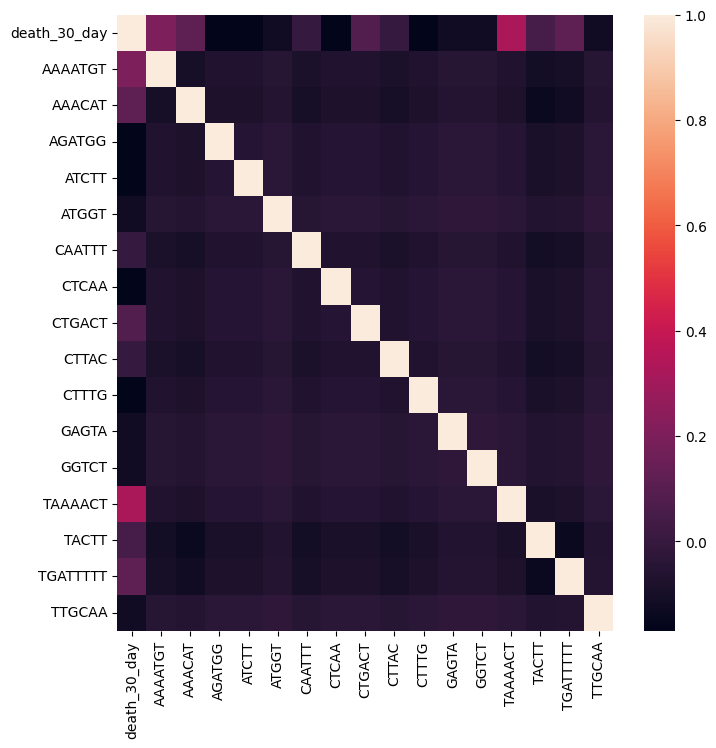

In [123]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from matplotlib.colors import SymLogNorm


f, ax = plt.subplots(1, 1, figsize=(8, 8))

# plot the heatmap
sns.heatmap(dataDf.drop(columns=['person_id', 'JOURNEY_ID']).corr())

### Plot correlations as a heatmap (Log scale)

<Axes: >

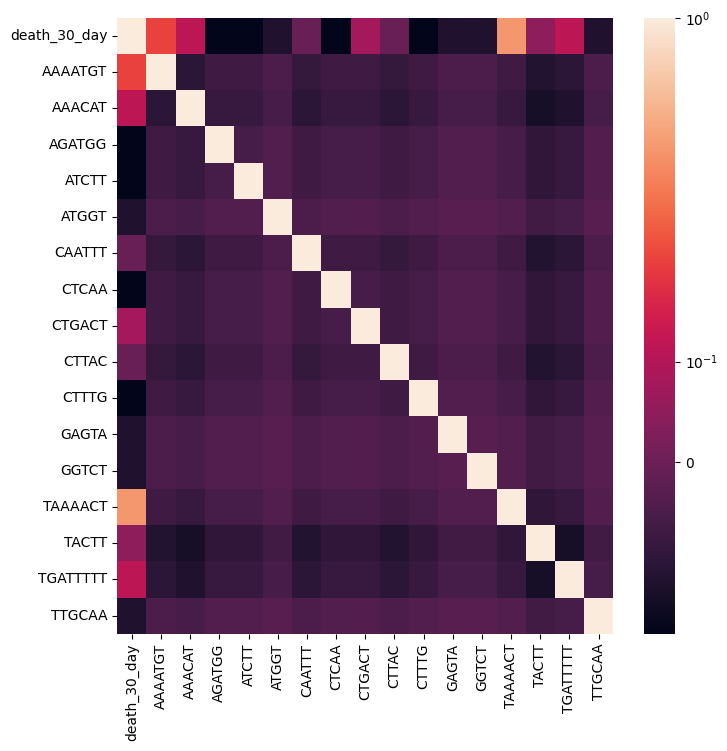

In [124]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from matplotlib.colors import SymLogNorm


f, ax = plt.subplots(1, 1, figsize=(8, 8))

# plot the heatmap
sns.heatmap(dataDf.drop(columns=['person_id', 'JOURNEY_ID']).corr(), norm=SymLogNorm(linthresh=0.3))

### Model using machine learning

In [125]:
X = dataDf.drop(columns=['person_id', 'JOURNEY_ID', 'death_30_day'])
y = dataDf.death_30_day

In [126]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)

accuracy_score(y_test, y_pred)

0.5

In [127]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
lrc = LogisticRegression(random_state=0)
y_pred = lrc.fit(X_train, y_train).predict(X_test)

accuracy_score(y_test, y_pred)

0.625

In [128]:
coefficients = lrc.coef_[0]
featureImportanceDf = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients
    }).sort_values(by=['Coefficient'])
featureImportanceDf

,Feature,Coefficient
6,CTCAA,-0.448064
9,CTTTG,-0.448064
3,ATCTT,-0.259083
1,AAACAT,-0.259083
4,ATGGT,-0.259083
15,TTGCAA,-0.259083
11,GGTCT,-0.259083
2,AGATGG,-0.259083
10,GAGTA,0.000000
8,CTTAC,0.040267


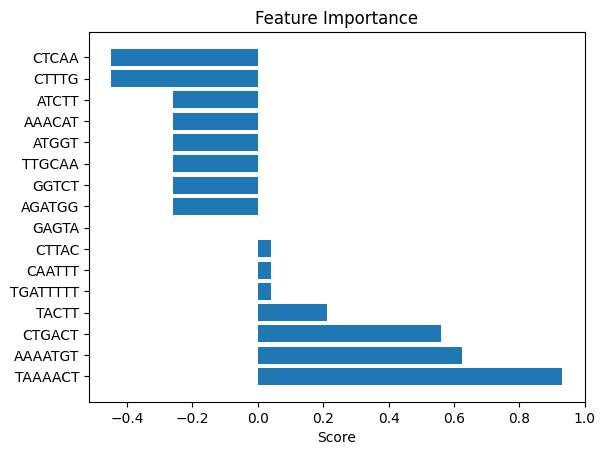

In [129]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots()

ax.barh(y=featureImportanceDf.Feature, width=featureImportanceDf.Coefficient, align='center')
# ax.set_yticks(y_pos, labels=people)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Score')
ax.set_title('Feature Importance')

plt.show()

### Get genes corresponding to the top tokens

#### Token `TAAAACT` (+ve feature importance)

In [132]:
overlappingDf[overlappingDf.tokens == 'TAAAACT'][['Gene symbol']].value_counts()[:20]

Gene symbol
mepA           13
tet(38)         4
hlgB            3
blaI            1
sei             1
Name: count, dtype: int64

`MepA`: An efflux protein regulated by MepR and part of the MepRAB cluster. Its presence in Staphylococcus aureus led to multidrug resistance, while it has also been shown to decrease tigecycline susceptibility.